In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
train_df = pd.read_csv('data/train.csv',delimiter=',',header=None,names=['text','label'])
val_df = pd.read_csv('data/validation.csv',delimiter=',',header=None,names=['text','label'])

In [4]:
print(train_df.shape)
print(val_df.shape)

(16800, 2)
(11200, 2)


In [5]:
# Used for the test results (refer to the last section)
import copy 
temp_df = copy.deepcopy(val_df)
temp_df.label = temp_df.label.apply({'CL':0,'CR':1,'DC':2,'DS':3,'LO':4, 'NI':5, 'SE':6}.get)

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
def clean(data):
    corpus = []
    rows = data.shape[0]
    for i in range(0, rows):
        title = re.sub('[^a-zA-Z]', ' ', data['text'][i])
        title = title.lower()
        title = word_tokenize(title)
        # title = title.split()
        ps = PorterStemmer()
        lemma = WordNetLemmatizer()
        all_stopwords = stopwords.words('english')
        title = [lemma.lemmatize(word) for word in title if not word in set(all_stopwords)]
        title = [ps.stem(word) for word in title if not word in set(all_stopwords)]
        title = ' '.join(title)
        corpus.append(title)
    return corpus

In [7]:
corpus_train = clean(train_df)
corpus_val = clean(val_df)

In [8]:
train_df['text'] = corpus_train
train_df.label = train_df.label.apply({'CL':0,'CR':1,'DC':2,'DS':3,'LO':4, 'NI':5, 'SE':6}.get)
val_df['text'] = corpus_val
val_df.label = val_df.label.apply({'CL':0,'CR':1,'DC':2,'DS':3,'LO':4, 'NI':5, 'SE':6}.get)

In [9]:
train_df.head()

,text,label
0,extend natur deduct approach linear nest seque...,4
1,last decad ieee emerg popular protocol wireles...,5
2,motiv problem store colour de bruijn graph sho...,3
3,consid downlink cellular system address proble...,5
4,meroit still undeciph languag ancient civil ku...,0


In [10]:
val_df.head()

,text,label
0,mann et al design first algorithm comput maxim...,2
1,consid challeng creat guidelin evalu qualiti s...,6
2,network virtual techniqu allow coexist mani vi...,5
3,min k cut problem input edg weight graph g int...,3
4,introduc notion weihrauch complet layerwis com...,4


In [11]:
from sklearn.model_selection import train_test_split
X = val_df['text']
y = val_df['label']
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)

In [12]:
test_df=pd.concat([X_test, y_test], axis=1)

In [13]:
test_df.head()

,text,label
3532,show np complet existenti theori term algebra ...,4
2899,rapid advanc sens network comput technolog rec...,5
3822,problem oblivi ram oram tradit studi singl ser...,1
5846,secur multi parti comput wide studi area compu...,1
9036,paper first present analyt discuss energi effi...,5


In [14]:
# For validation using K-Fold Cross Validation
# text = np.array(val_df['text'])
# label = np.array(val_df['label'])

text = np.array(train_df['text'])
label = np.array(train_df['label'])

In [15]:
text_train = train_df['text']
text_test = test_df['text']
label_train = train_df['label']
label_test = test_df['label']

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
# build TFIDF features on train reviews
tv = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(text_train)

In [17]:
# transform test reviews into features
tv_test_features = tv.transform(text_test)

In [18]:
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

TFIDF model:> Train features shape: (16800, 727983)  Test features shape: (5600, 727983)


In [19]:
# Report for all models
from collections import defaultdict
scores = defaultdict(lambda: [0] * 4)

In [20]:
####Evaluation metrics
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns


def fetch_scores(classifier_name ,true_labels, predicted_labels):
    scores[classifier_name][0]=(np.round(metrics.accuracy_score(true_labels, predicted_labels), 4))
    scores[classifier_name][1]=(np.round(metrics.precision_score(true_labels, predicted_labels, average='weighted'), 4))
    scores[classifier_name][2]=(np.round(metrics.recall_score(true_labels, predicted_labels, average='weighted'), 4))
    scores[classifier_name][3]=(np.round(metrics.f1_score(true_labels, predicted_labels, average='weighted'), 4))
    

def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
                        

def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    


def cross_validate_model(classifier, 
                        text, label, k=5):
    print('\nModel Validation Report:')
    print('-'*30)
    # build model    
    classifier.fit(text, label)
    # validate the model
    scores = cross_val_score(classifier, text, label, cv=k)
    for i in range(len(scores)):
        print('Fold', i + 1,':', np.round(scores[i], 2))
    print('\nMin Score:', np.round(np.array(scores).min(), 4))
    print('Max Score:', np.round(np.array(scores).max(), 4))
    print('Mean Score:', np.round(np.array(scores).mean(), 4))


def stratified_cross_validate_model(classifier, 
                        text, label, k=5):
    print('\nModel Validation Report:')
    print('-'*30)
    
    skf = StratifiedKFold(n_splits=k, random_state=None)
    skf.get_n_splits(text, label)
    
    scores = []
    for train_index, test_index in skf.split(text, label):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = text[train_index], text[test_index]
        y_train, y_test = label[train_index], label[test_index]
        
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        
        accuracy = metrics.accuracy_score(y_test, y_pred)
        scores.append(accuracy)

    for i in range(len(scores)):
        print('Fold', i + 1,':', np.round(scores[i], 2))
    print('\nMin Score:', np.round(np.array(scores).min(), 4))
    print('Max Score:', np.round(np.array(scores).max(), 4))
    print('Mean Score:', np.round(np.array(scores).mean(), 4))    
    
    
def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    
    labels = classes
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)


# Ensemble Learning 

In [21]:
best_params_sgd={'loss': 'modified_huber'}
best_params_svm1={'random_state': 1, 'kernel': 'linear', 'gamma': 10, 'C': 10}
best_params_svm2={'random_state': 1, 'kernel': 'linear', 'gamma': 10, 'C': 10, 'probability': True}

## Hard Voting 

Model Performance metrics:
------------------------------
Accuracy: 0.925
Precision: 0.9249
Recall: 0.925
F1 Score: 0.9247

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       934
           1       0.93      0.90      0.92       946
           2       0.88      0.82      0.85       647
           3       0.92      0.96      0.94       891
           4       0.93      0.94      0.94       615
           5       0.92      0.92      0.92       919
           6       0.89      0.92      0.90       648

    accuracy                           0.93      5600
   macro avg       0.92      0.92      0.92      5600
weighted avg       0.92      0.93      0.92      5600


Prediction Confusion Matrix:
------------------------------
[[916   2   0   1   7   0   8]
 [  2 855  12  13  12  28  24]
 [  1  19 532  34   2  35  24]
 [  1   4  22 854   5   5   0]
 [  4   4   5  12 577   0  13]
 [ 

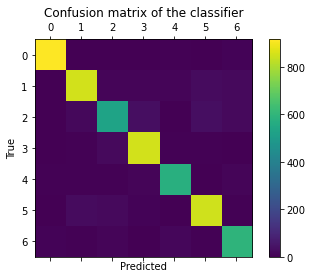

In [22]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

estimators = []
log_reg = LogisticRegression(solver='liblinear')
estimators.append(('Logistic', log_reg))

sgd_clf = SGDClassifier(**best_params_sgd)
estimators.append(('SGD', sgd_clf))

svm_clf = SVC(**best_params_svm1)
estimators.append(('SVM', svm_clf))

# Build the final Ensemble model using voting paradigm
voting_hard = VotingClassifier(estimators=estimators)


voting_tfidf_predictions_hard = train_predict_model(classifier=voting_hard, 
                                                train_features=tv_train_features, train_labels=label_train,
                                                test_features=tv_test_features, test_labels=label_test)

display_model_performance_metrics(true_labels=label_test, predicted_labels=voting_tfidf_predictions_hard,
                                      classes=[0,1,2,3,4,5,6])

fetch_scores(classifier_name = 'Ensemble Model (Hard Voting)', true_labels=label_test, 
                                     predicted_labels=voting_tfidf_predictions_hard)

# stratified_cross_validate_model(classifier=voting_hard, text=tv.fit_transform(text), label=label, k=10)

## Soft Voting 

Model Performance metrics:
------------------------------
Accuracy: 0.9254
Precision: 0.9253
Recall: 0.9254
F1 Score: 0.9251

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       934
           1       0.94      0.90      0.92       946
           2       0.88      0.83      0.85       647
           3       0.93      0.96      0.94       891
           4       0.93      0.94      0.93       615
           5       0.92      0.93      0.92       919
           6       0.89      0.91      0.90       648

    accuracy                           0.93      5600
   macro avg       0.92      0.92      0.92      5600
weighted avg       0.93      0.93      0.93      5600


Prediction Confusion Matrix:
------------------------------
[[918   1   0   1   7   0   7]
 [  4 849  13  12  12  30  26]
 [  1  17 540  30   2  36  21]
 [  1   3  22 855   5   5   0]
 [  3   4   5  11 577   0  15]
 

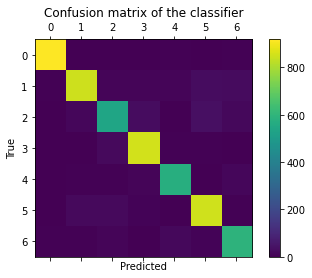

In [23]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

estimators = []
log_reg = LogisticRegression(solver='liblinear')
estimators.append(('Logistic', log_reg))

sgd_clf = SGDClassifier(**best_params_sgd)
estimators.append(('SGD', sgd_clf))

svm_clf = SVC(**best_params_svm2)
estimators.append(('SVM', svm_clf))

# Build the final Ensemble model using voting paradigm
voting_soft = VotingClassifier(estimators=estimators, voting='soft')


voting_tfidf_predictions_soft = train_predict_model(classifier=voting_soft, 
                                                train_features=tv_train_features, train_labels=label_train,
                                                test_features=tv_test_features, test_labels=label_test)

display_model_performance_metrics(true_labels=label_test, predicted_labels=voting_tfidf_predictions_soft,
                                      classes=[0,1,2,3,4,5,6])

fetch_scores(classifier_name = 'Ensemble Model (Soft Voting)', true_labels=label_test, 
                                     predicted_labels=voting_tfidf_predictions_soft)

# stratified_cross_validate_model(classifier=voting_soft, text=tv.fit_transform(text), label=label, k=10)

# All Model Report

In [24]:
print(scores)

defaultdict(<function <lambda> at 0x000001F5D785B8B0>, {'Ensemble Model (Hard Voting)': [0.925, 0.9249, 0.925, 0.9247], 'Ensemble Model (Soft Voting)': [0.9254, 0.9253, 0.9254, 0.9251]})


In [25]:
mp = {0: 'Accuracy', 1: 'Precision', 2: 'Recall', 3: 'F1 Score'}
best_accuracy, best_precision, best_recall, best_f1score = 0.0, 0.0, 0.0, 0.0
for model, parameters in scores.items():
    print(model)
    print('-'*33)
    i = 0
    for p in parameters:
        best_accuracy = max(best_accuracy, parameters[0])
        best_precision = max(best_precision, parameters[1])
        best_recall = max(best_recall, parameters[2])
        best_f1score = max(best_f1score, parameters[3])
        print(' ', mp[i] + (' ' * (20-len(mp[i]))), p)
        i = i+1
    print('')

Ensemble Model (Hard Voting)
---------------------------------
  Accuracy             0.925
  Precision            0.9249
  Recall               0.925
  F1 Score             0.9247

Ensemble Model (Soft Voting)
---------------------------------
  Accuracy             0.9254
  Precision            0.9253
  Recall               0.9254
  F1 Score             0.9251



In [26]:
best_accuracy_models, best_precision_models, best_recall_models, best_f1score_models = [], [], [], []
for model, parameters in scores.items():
    i = 0
    for p in parameters:
        if parameters[0] is best_accuracy: best_accuracy_models.append(model)
        if parameters[1] is best_precision: best_precision_models.append(model)
        if parameters[2] is best_recall: best_recall_models.append(model)
        if parameters[3] is best_f1score: best_f1score_models.append(model)
        i = i+1

print('Best Accuracy:', best_accuracy, '\nModels:', set(best_accuracy_models))
print('\nBest Precision:', best_precision, '\nModels:', set(best_precision_models))
print('\nBest Recall:', best_accuracy, '\nModels:', set(best_recall_models))
print('\nBest F1 Score:', best_f1score, '\nModels:', set(best_f1score_models))

Best Accuracy: 0.9254 
Models: {'Ensemble Model (Soft Voting)'}

Best Precision: 0.9253 
Models: {'Ensemble Model (Soft Voting)'}

Best Recall: 0.9254 
Models: {'Ensemble Model (Soft Voting)'}

Best F1 Score: 0.9251 
Models: {'Ensemble Model (Soft Voting)'}


# User Prediction Section

In [27]:
hash_mp = {0:'CL', 1:'CR', 2:'DC', 3:'DS', 4:'LO', 5:'NI', 6:'SE'}
def user_predict(abstract, model):
    processed_abstract = re.sub('[^a-zA-Z]', ' ', abstract)
    processed_abstract = processed_abstract.lower()
    processed_abstract = word_tokenize(processed_abstract)
    ps = PorterStemmer()
    lemma = WordNetLemmatizer()
    all_stopwords = stopwords.words('english')
    processed_abstract = [lemma.lemmatize(word) for word in processed_abstract if not word in set(all_stopwords)]
    processed_abstract = [ps.stem(word) for word in processed_abstract if not word in set(all_stopwords)]
    processed_abstract = ' '.join(processed_abstract)
    category = model.predict(tv.transform([processed_abstract]))
    # print(hash_mp[category[0]])
    return hash_mp[category[0]]

In [28]:
model = voting_soft# Chose a model
abstract = train_df['text'][0]# String
print(user_predict(abstract, model))

LO


In [29]:
# 4 5 3 5 0

# Save File

In [30]:
temp_df.head()

,text,label
0,Manne et al. designed the first algorithm co...,2
1,We consider the challenge of creating guidel...,6
2,Network virtualization techniques allow for ...,5
3,"In the Min $k$-Cut problem, input is an edge...",3
4,We introduce the notion of being Weihrauch-c...,4


In [31]:
X_tmp = temp_df['text']
y_tmp = temp_df['label']
X_val_tmp, X_test_tmp, y_val_tmp, y_test_tmp = train_test_split(X_tmp, y_tmp, test_size = 0.5, random_state = 42)

In [32]:
# HARD
df_results_ensemble_hard = pd.DataFrame(list(zip(X_test_tmp, label_test.tolist(),voting_tfidf_predictions_hard.tolist())),
                          columns = ['text','true_labels','pred_labels'])

# SOFT
df_results_ensemble_soft = pd.DataFrame(list(zip(X_test_tmp, label_test.tolist(),voting_tfidf_predictions_soft.tolist())),
                          columns = ['text','true_labels','pred_labels'])

In [33]:
df_results_ensemble_hard.to_csv('all_results_ensemble_hard_voting.csv')
df_results_ensemble_soft.to_csv('all_results_ensemble_soft_voting.csv')

### HARD VOTING (WRONG RESULTS)

In [34]:
trueLabels = df_results_ensemble_hard['true_labels']
predLabels = df_results_ensemble_hard['pred_labels']


wrongLabels_true = []
wrongLabels_pred = []
wrongText = []
cnt = 0
for i in range(len(trueLabels)):
    if trueLabels[i] != predLabels[i]:
        cnt += 1
        wrongLabels_true.append(trueLabels[i])
        wrongLabels_pred.append(predLabels[i])
        wrongText.append(temp_df['text'][i])    
print(cnt)

420


In [35]:
df_results_ensemble_hard_wrong = pd.DataFrame(list(zip(wrongText, wrongLabels_true,wrongLabels_pred)),
                          columns = ['text','true_labels','pred_labels'])

In [36]:
df_results_ensemble_hard_wrong.to_csv('wrong_results_ensemble_hard_voting.csv')

### SOFT VOTING (WRONG RESULTS)

In [37]:
trueLabels = df_results_ensemble_soft['true_labels']
predLabels = df_results_ensemble_soft['pred_labels']


wrongLabels_true = []
wrongLabels_pred = []
wrongText = []
cnt = 0
for i in range(len(trueLabels)):
    if trueLabels[i] != predLabels[i]:
        cnt += 1
        wrongLabels_true.append(trueLabels[i])
        wrongLabels_pred.append(predLabels[i])
        wrongText.append(temp_df['text'][i])    
print(cnt)

418


In [38]:
df_results_ensemble_soft_wrong = pd.DataFrame(list(zip(wrongText, wrongLabels_true,wrongLabels_pred)),
                          columns = ['text','true_labels','pred_labels'])

In [39]:
df_results_ensemble_soft_wrong.to_csv('wrong_results_ensemble_soft_voting.csv')

In [40]:
##